# Tracing sport object

## Submitted by: 
###             name: Shoval Tanami id:205627920
###             name: Ahikam Partush id:204072524

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Auxiliary functions

In [2]:

def prepareFrame(frame,size):
    frame =cv2.resize(frame, size)
    frame_gray =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return frame, frame_gray

def getOutputWriter(size, fileName): 
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    return cv2.VideoWriter(fileName + '_out.mp4',fourcc, 20.0,size)

def plotImage(img, cmap='viridis'):
    plt.figure(figsize = (10,10))
    plt.imshow(img,cmap=cmap)
    plt.colorbar(fraction=0.02)     
    plt.axis('off')
    plt.show()
    

###  Auxiliary functions-creating map of objects rapid

In [3]:
#Here we creating the map of the movement objects, in this way we focuses the goodFeaturesToTrack function for 
#specific locations
#here we using with the calcOpticalFlowFarneback method ,this method returns the matrice of rapidity of any pixel

def initTotalFlow(frame):
    h,w,_ = frame.shape
    return np.zeros((h//4,w//4))  

def getSize(frame):
    h,w,_ = frame.shape
    return (w//4,h//4)

def createFastMap(fileName):
    cap = cv2.VideoCapture(fileName)
    ret,F0 = cap.read()
    size = getSize(F0)
    total_flow = initTotalFlow(F0)
    _,F0 =prepareFrame(F0,size)

    while(True):
        ret,F1 = cap.read()
        ret,F1 = cap.read()
        if ret==True:
            _,F1 = prepareFrame(F1,size)
            flow = cv2.calcOpticalFlowFarneback(F0,F1,None,0.5,3,15,3,5,1.2,0)
            flow = np.sum(flow**2,axis=2)
            total_flow += flow    
            F0 = F1
        else:
            break
            
    return np.sqrt(total_flow)


## Auxiliary functions- getting the new points for tracking.

In [4]:
#using calcOpticalFlowPyrLK to find the new points in the next frame, In addition we checking if 
#the point status has saved.
def getPtsCalcOpticalFlow(F0_gray,F1_gray, pts0, lk_params):
    pts1, st, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)  
    pts1 = pts1[st[:,0]==1]
    pts0 = pts0[st[:,0]==1]
    return pts0, pts1

#creating canvas,point coloring , and painting the lines between two points.
def createCanvas(pts0,pts1,canvas,F1): 
    for (p0,p1) in zip(pts0,pts1):
        x0,y0 = p0
        x1,y1 = p1
        if(abs(y0-y1) > 10.5 or abs(x0-x1) >10.5):
            canvas = cv2.line(canvas, (x0,y0),(x1,y1), (0,255,255), 8) 
            F1 = cv2.circle(F1,(x1,y1),5,(0,0,255),-1)
    canvas = np.uint8(canvas*0.8) # fade out canvas
    return canvas


In [5]:
#using canny function to create frames with canny lines
def addcanny(frame, size) : 
    frame = cv2.resize(frame, size) 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
    canny = cv2.Canny(gray,200,200)
    canny =cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)
    return canny

## Auxiliary function-creating the videos 

In [6]:
#This function role is to create the videos and export them. we using here with goodFeatureToTrack function
#we using here with goodFeatureToTrack function on porpuse to get good points for tracking.
#we using here with getPtsCalcOpticalFlow function on porpuse to get the next frame points.
def createVideo(fileName, mask=None):
    size = (640,360)
    cap = cv2.VideoCapture(fileName + ".mp4")
    out = getOutputWriter(size, fileName)
    canny_out = getOutputWriter(size, "canny_" + fileName)   
    
    ret,F0 = cap.read()
    F0 ,F0_gray = prepareFrame(F0,size)

    feature_params = dict( maxCorners = 1500,qualityLevel = 0.3,minDistance = 5,blockSize = 8 )
    lk_params = dict( winSize  = (10,10),maxLevel = 5,criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = mask, **feature_params)
    pts0 = pts0.squeeze() 
    canvas = np.zeros_like(F0)

    while(1):
        ret,F1 = cap.read()
        ret,F1 = cap.read()

        if ret==True:

            F1 ,F1_gray = prepareFrame(F1,size)
            canny = addcanny(F1,size)

            pts0, pts1 = getPtsCalcOpticalFlow(F0_gray,F1_gray, pts0, lk_params)
            canvas= createCanvas(pts0,pts1,canvas,F1)
            
            img = cv2.add(F1, canvas)
            img_canny= cv2.add(canvas,canny)

            F0_gray= F1_gray
            pts0 = pts1

            cv2.imshow('frame',img)
            cv2.imshow('canny',img_canny)

            out.write(img)
            canny_out.write(img_canny)
         
            k = cv2.waitKey(20) & 0xff
            if k == 27:
                break

        else: 
            break

    cv2.destroyAllWindows()
    cap.release()
    out.release()
    canny_out.release()
    cv2.waitKey(1)

# Video 1

In [7]:
name = 'sport_swing'
fileName = name + '.mp4'

## Image 1 - creating map of objects rapid

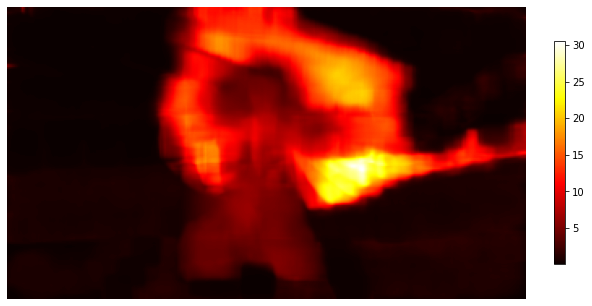

In [8]:
#on purpuse to limit the option choices we creating limited mask
total_flow = createFastMap(fileName)
plotImage(total_flow, 'hot')  

### adding terms and creating the mask

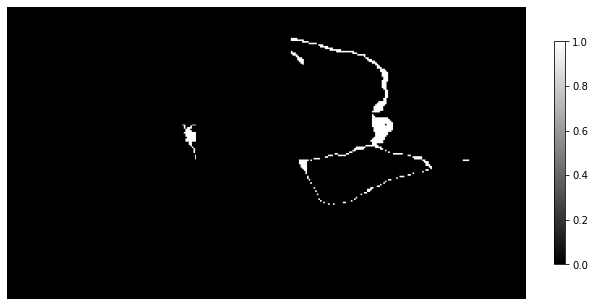

In [9]:
#adding some terms to create the limited mask
mask = ((total_flow>14) & (total_flow<15)).astype(np.uint8)
mask=cv2.resize(mask, (640,360))

for i, x in enumerate(mask):
    for j, y in  enumerate(x):
#         remove dots on hand
        if ((int(i) >80)  & (int(i) < 145)  &(int(j) > 100)  & (int(j) < 250)):
             mask[i, j]=0
        if ((int(i) >80)  & (int(i) < 300)  &(int(j) > 232)  & (int(j) < 300)):
             mask[i, j]=0
#         remove dots around 
        if ((int(i) >0)  & (int(i) < 70)  &(int(j) > 230)  & (int(j) < 350)):
             mask[i, j]=0  
        if ((int(i) >70)  & (int(i) < 150)  &(int(j) > 300)  & (int(j) < 450)):
             mask[i, j]=0
        
plotImage(mask, cmap='gray')

## Creating new video 1

In [10]:
#creating first video
createVideo(name, mask)

# Video 2 

In [11]:
name = 'sport_pitching'
fileName = name + '.mp4'

## Creating new video 1

In [12]:
#creating second video
createVideo(name)